# Module Import

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import time

from tqdm import tqdm
from sklearn.model_selection import train_test_split

##부모파일에 있는 py파일 읽기
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('load_data.py'))))
 
from load_data import load_data_using_multi_process
from model import model_lgbm
from make_roc_curve import make_roc_curve

from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, precision_score

/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
obj = 'fan'
model0 = '0'
model_6 = '_6'
model6 = '6'
id_name = 'id_00'
sr = 16000
target_sr = 125


# modeling_Model
model별로 [0, _6, 6]노이즈를 합쳐서 모델링하기

## 함수 정의

In [26]:

def modeling_Model(obj:str, id_name:str, sr:int, target_sr:int):
    '''
    model별로 [0, _6, 6]노이즈를 합쳐서 모델링하기
        input
            obj : Object-ex)'fan'
            id_name : 합치고 싶은 id_name - ex)'id_00'
            sr : sample rate - ex)16000
            target_sr : down sampling rate - ex)125
        output
            make_roc_curve함수
                - acc_score
                - recall_score
                - precision_score
                - f1_score
                - roc auc value
    '''

    model0 = '0'
    model_6 = '_6'
    model6 = '6'
    
    print('#'*10, '데이터 로드', '#'*10)
    ##fan_0_
    fan_0_id_00_path = '/data/time_series/'+obj+'/'+model0+'/' + id_name
    fan_0_id_00_files = glob.glob(fan_0_id_00_path + '/*/*')
    print(obj+'_'+model0+'_id_00_files 개수 : ', len(fan_0_id_00_files))
    print('\n')

    ##fan__6_
    fan__6_id_00_path = '/data/time_series/'+obj+'/'+model_6+'/' + id_name
    fan__6_id_00_files = glob.glob(fan__6_id_00_path + '/*/*')
    print(obj+'_'+model_6+'_id_00_files 개수 : ', len(fan__6_id_00_files))
    print('\n')

    ##fan_0_
    fan_6_id_00_path = '/data/time_series/'+obj+'/'+model6+'/' + id_name
    fan_6_id_00_files = glob.glob(fan_6_id_00_path + '/*/*')
    print(obj+'_'+model6+'_id_00_files 개수 : ', len(fan_6_id_00_files))
    print('\n')

    print('#'*10, 'Multi Processing', '#'*10)

    fan_0_ = load_data_using_multi_process(files = fan_0_id_00_files, sr = sr, target_sr = target_sr)
    fan__6_ = load_data_using_multi_process(files = fan__6_id_00_files, sr = sr, target_sr = target_sr)
    fan_6_= load_data_using_multi_process(files = fan_6_id_00_files, sr = sr, target_sr = target_sr)

    if (len(fan_0_[0]) == (target_sr*10 + 1)) & (len(fan__6_[0])==(target_sr*10 + 1)) & (len(fan_6_[0])==(target_sr*10 + 1)):
        fan_0_ = pd.DataFrame(fan_0_)
        fan__6_ = pd.DataFrame(fan__6_)
        fan_6_ = pd.DataFrame(fan_6_)

    df = pd.concat([fan_0_,fan__6_,fan_6_])

    if df.columns[-1] == target_sr*10 :
        df.rename(columns={target_sr*10:'label'}, inplace=True)

    df.reset_index(drop=True, inplace=True)
    
    print('\n')
    print('#'*10, 'Data Split', '#'*10, '\n')

    X = df.iloc[:, :target_sr*10]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        stratify = y,
                                                        test_size = 0.2,
                                                        random_state = 42)
    print('X_train 의 크기 : ', X_train.shape)
    print('X_test 의 크기 : ', X_test.shape)
    print('y_train 의 크기 : ', y_train.shape)
    print('y_test 의 크기 : ', y_test.shape)
    print('\n')
    
    print('#'*10, 'Modeling', '#'*10)

    model = model_lgbm(df)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    print('#'*10, 'ROC커브 그리기', '#'*10)
    return make_roc_curve(y_test, y_pred, y_pred_prob)




## 함수사용

########## 데이터 로드 ##########
fan_0_id_00_files 개수 :  1375


fan__6_id_00_files 개수 :  1375


fan_6_id_00_files 개수 :  1375


########## Multi Processing ##########

아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: kaiser_best

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 6.779499292373657 ---

아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: kaiser_best

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 6.762294054031372 ---

아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fas

/package/anaconda3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


########## ROC커브 그리기 ##########


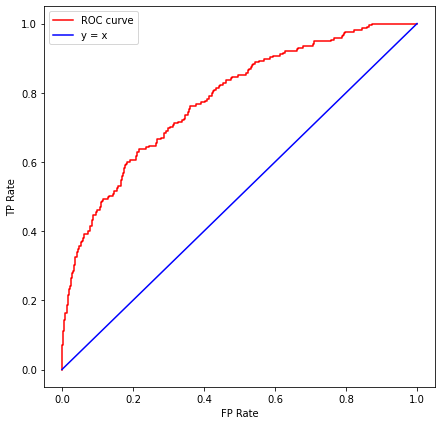

acc_score : 0.778
recall_score : 0.2
precision_score : 0.796
f1_score : 0.32
roc auc value : 0.78


In [11]:
aa = modeling_Model('fan', 'id_02', 16000, 125)

In [12]:
aa

(0.778, 0.32, 0.2, 0.796)

# modeling_Noise
- Noise별로 모델링을 진행함

In [15]:
obj = 'fan'
model = '0'
sr = 16000
target_sr = 125


## 함수정의

In [24]:
def modeling_Noise(obj:str, model:str, sr:int, target_sr:int):
    '''
    Noise별로 모델링을 진행함
    input :
        - obj : Object - ex)'fan'
        - model : 모델링하고 싶은 모델 - ex)'0'
        - sr : sampling rate - ex)16000
        - target_sr : down sampling rate - ex)125
    output :
        make_roc_curve함수
            - acc_score
            - recall_score
            - precision_score
            - f1_score
            - roc auc value
    '''
    
    print('#'*10, '데이터 경로 불러오기', '#'*10)
    fan_0_id_00_path = '/data/time_series/'+obj+'/'+model
    all_fan_0 = glob.glob(fan_0_id_00_path + '/*/*/*')
    print(obj+'_'+model+' 개수 : ', len(all_fan_0))
    print('\n')

    print('#'*10, 'Multi-Processing', '#'*10)
    fan_all_model = load_data_using_multi_process(files = all_fan_0, sr = sr, target_sr = target_sr)

    if len(fan_all_model[0]) == (target_sr*10)+1:
        df = pd.DataFrame(fan_all_model)

    if df.columns[-1] == target_sr*10 :
        df.rename(columns={target_sr*10:'label'}, inplace=True)
    df.reset_index(drop=True, inplace=True)   
    print('\n')

    print('#'*10, 'Data Split', '#'*10)
    X = df.iloc[:, :target_sr*10]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        stratify = y,
                                                        test_size = 0.2,
                                                        random_state = 42)
    print('X_train 의 크기 : ', X_train.shape)
    print('X_test 의 크기 : ', X_test.shape)
    print('y_train 의 크기 : ', y_train.shape)
    print('y_test 의 크기 : ', y_test.shape)
    print('\n')

    print('#'*10, 'Modeling', '#'*10)
    model = model_lgbm(df)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    print('#'*10, 'ROC_CURVE', '#'*10)
    return make_roc_curve(y_test, y_pred, y_pred_prob)
    
    
    
    

## 함수 사용

########## 데이터 경로 불러오기 ##########
fan_0 개수 :  5550


########## Multi-Processing ##########

아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: kaiser_best

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 11.593631029129028 ---


########## Data Split ##########
X_train 의 크기 :  (4440, 1250)
X_test 의 크기 :  (1110, 1250)
y_train 의 크기 :  (4440,)
y_test 의 크기 :  (1110,)


########## Modeling ##########
normal : 4075
abnormal : 1475
scale_pos_weight is 2.76.
Model is ready to running.


/package/anaconda3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


########## ROC_CURVE ##########


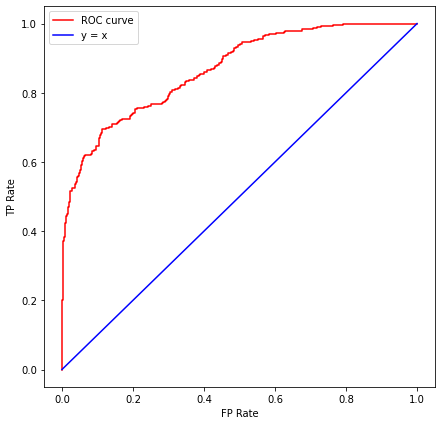

acc_score : 0.842
recall_score : 0.444
precision_score : 0.923
f1_score : 0.6
roc auc value : 0.867


In [21]:
bb = modeling_Noise('fan', '0', 16000, 125)

In [23]:
bb

(0.842, 0.6, 0.444, 0.923)

# modeling_Object

In [30]:
obj = 'fan'
sr = 16000
target_sr = 125

## 함수정의

In [36]:
def modeling_Object(obj:str, sr:int, target_sr:int):
    '''
    원하는 Object를 전체로 모델링 돌리기
        input :
            - obj 모델링 돌리고 싶은 Object - ex)'fan'
            - sr : sampling rate - ex)16000
            - target_sr : down sampling rate - ex)125
        output : 
            make_roc_curve함수
                - acc_score
                - recall_score
                - precision_score
                - f1_score
                - roc auc value
    '''

    print('#'*10, '파일경로 불러오기', '#'*10)
    fan_path = '/data/time_series/' + obj
    fan_files = glob.glob(fan_path + '/*/*/*/*')
    print('\n')

    print('#'*10, 'Multi-Processing', '#'*10)
    result = load_data_using_multi_process(files = fan_files, sr = sr, target_sr = target_sr)

    if len(result[0]) == (target_sr*10)+1:
        df = pd.DataFrame(result)

    if df.columns[-1] == target_sr*10 :
        df.rename(columns={target_sr*10:'label'}, inplace=True)
    print('\n')

    print('#'*10, 'Data Split', '#'*10)
    X = df.iloc[:, :target_sr*10]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        stratify = y,
                                                        test_size = 0.2,
                                                        random_state = 42)
    print('X_train 의 크기 : ', X_train.shape)
    print('X_test 의 크기 : ', X_test.shape)
    print('y_train 의 크기 : ', y_train.shape)
    print('y_test 의 크기 : ', y_test.shape)
    print('\n')

    print('#'*10, 'Modeling', '#'*10)
    model = model_lgbm(df)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    print('\n')
    
    print('#'*10, 'ROC_CURVE', '#'*10)
    return make_roc_curve(y_test, y_pred, y_pred_prob)



## 함수 사용

########## 파일경로 불러오기 ##########


########## Multi-Processing ##########

아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: kaiser_best

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 32.934669971466064 ---


########## Data Split ##########
X_train 의 크기 :  (13320, 1250)
X_test 의 크기 :  (3330, 1250)
y_train 의 크기 :  (13320,)
y_test 의 크기 :  (3330,)


########## Modeling ##########
normal : 12225
abnormal : 4425
scale_pos_weight is 2.76.
Model is ready to running.


/package/anaconda3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")




########## ROC_CURVE ##########


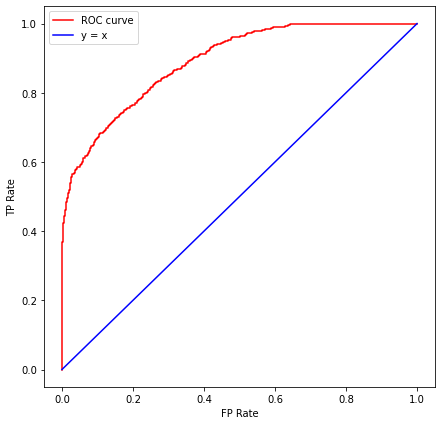

acc_score : 0.862
recall_score : 0.551
precision_score : 0.884
f1_score : 0.679
roc auc value : 0.891


In [38]:
cc = modeling_Object('fan', 16000, 125)

In [39]:
cc

(0.862, 0.679, 0.551, 0.884)